In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*`torch.cuda.amp.autocast.*")
import torch
import numpy as np
import random
import PIL.Image
import matplotlib.pyplot as plt
from types import SimpleNamespace
from collections import Counter
from glob import glob
from torch.utils.data import WeightedRandomSampler
from datasets import load_dataset
from timm.optim import Mars
from torchvision.transforms.v2 import (
    Compose, Resize, RandomCrop, CenterCrop,
    PILToTensor, ToPILImage, MixUp, CutMix )
from fastprogress.fastprogress import master_bar, progress_bar
from IPython.display import display, HTML

In [2]:
torch.set_float32_matmul_precision('high')
device = "cuda:2"
dataset = load_dataset('danjacobellis/bloodmnist_224')

In [3]:
labels = [l[0] for l in dataset['train']['label']]
class_counts = Counter(labels)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in labels]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [4]:
config = SimpleNamespace()
# Training and optimizer config
config.batch_size = 128
config.steps_per_epoch = dataset['train'].num_rows//config.batch_size
config.grad_accum_steps = 1
config.max_lr = (config.batch_size/128)*6e-4
config.min_lr = config.max_lr/100
config.plot_update = 64
config.epochs = 200
config.lr_scale = 40
config.lr_offset = 0.25
config.lr_pow = 6
config.weight_decay = 0.
config.num_workers = 12
config.image_size = 272
config.crop_size = 256
config.target_acc = 0.993
config.N_median = 15

# model config
config.channels = 3
config.J = 4
config.embed_dim = 256
config.dim_head = 32
config.exp_ratio = 4.0
config.classifier_num_classes = 8
config.checkpoint = False

In [5]:
import torch
import einops
import numpy as np
from timm.models.maxxvit import TransformerBlock2d, MaxxVitTransformerCfg, LayerScale2d

class RMSNormAct(torch.nn.Module):
    def __init__(self, normalized_features):
        super(RMSNormAct, self).__init__()
        self.norm = torch.nn.RMSNorm(normalized_features)
        self.act = torch.nn.GELU()

    def forward(self, x):
        x = self.norm(x)
        x = self.act(x)
        return x

class InvertedResidual2D(torch.nn.Module):
    def __init__(self, in_dim, out_dim, spatial_dim, exp_ratio):
        super(InvertedResidual2D, self).__init__()
        self.exp_dim = int(in_dim * exp_ratio)
        self.pw_exp = torch.nn.Sequential(
            torch.nn.Conv2d(in_dim, self.exp_dim, kernel_size=1, stride=1, bias=False),
            RMSNormAct((self.exp_dim, spatial_dim, spatial_dim))
        )
        self.dw_mid = torch.nn.Sequential(
            torch.nn.Conv2d(self.exp_dim, self.exp_dim, kernel_size=3, stride=1, padding=1, groups=self.exp_dim, bias=False),
            RMSNormAct((self.exp_dim, spatial_dim, spatial_dim))
        )
        self.se = torch.nn.Identity()
        self.pw_proj = torch.nn.Sequential(
            torch.nn.Conv2d(self.exp_dim, out_dim, kernel_size=1, stride=1, bias=False),
            torch.nn.RMSNorm((out_dim, spatial_dim, spatial_dim)) 
        )
        self.dw_end = torch.nn.Identity()
        self.layer_scale = LayerScale2d(out_dim)
        self.drop_path = torch.nn.Identity()
        
    def forward(self, x):
        shortcut = x if x.shape[1] == self.pw_proj[0].out_channels else None
        x = self.pw_exp(x)
        x = self.dw_mid(x)
        x = self.se(x)
        x = self.pw_proj(x)
        x = self.dw_end(x)
        x = self.layer_scale(x)
        x = self.drop_path(x)
        if shortcut is not None:
            x += shortcut
        return x

class AsCAN2D(torch.nn.Module):
    def __init__(self, input_dim, embed_dim, spatial_dim, dim_head, exp_ratio):
        super().__init__()
        cfg = MaxxVitTransformerCfg(dim_head=dim_head)
        C=lambda:InvertedResidual2D(embed_dim, embed_dim, spatial_dim, exp_ratio)
        T=lambda:TransformerBlock2d(embed_dim,embed_dim,cfg)
        self.layers=torch.nn.Sequential(
            torch.nn.Conv2d(input_dim,embed_dim,kernel_size=1),
            RMSNormAct((embed_dim, spatial_dim, spatial_dim)),
            C(),C(),C(),T(),
            C(),C(),T(),T(),
            C(),T(),T(),T()
        )
    def forward(self,x):
        return self.layers(x)
        
        
class TFTClassifier2D(torch.nn.Module):
    def __init__(self, config, wpt):
        super().__init__()
        self.wpt = wpt
        self.ascan = AsCAN2D(
            input_dim=config.channels*(4**config.J),
            embed_dim=config.embed_dim,
            spatial_dim=config.crop_size//(2**config.J),
            dim_head=config.dim_head,
            exp_ratio=config.exp_ratio
        )
        self.pool = torch.nn.AdaptiveAvgPool2d((1,1))
        self.classifier = torch.nn.Sequential(
            torch.nn.Conv2d(config.embed_dim, config.classifier_num_classes, kernel_size=1),
            torch.nn.Flatten()
        )
    def forward(self,x):
        x = self.wpt(x)
        x = self.ascan(x)
        x = self.pool(x)
        return self.classifier(x)

In [6]:
from pytorch_wavelets import DWTForward
from tft.transforms import WPT2D
# from tft.models import TFTClassifier2D

wt = DWTForward(J=1, mode='periodization', wave='bior4.4')
wpt = WPT2D(wt).to(device)
model = TFTClassifier2D(config,wpt).to(device)

for name, module in model.named_children():
    print(f"{sum(p.numel() for p in module.parameters())/1e6} \t {name}")

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint, map_location="cpu", weights_only=False)
    model.load_state_dict(checkpoint['model'])

0.0 	 wpt
11.742464 	 ascan
0.0 	 pool
0.002056 	 classifier


In [7]:
mix_transforms = [
    CutMix(num_classes=config.classifier_num_classes, alpha=1.),
    MixUp(num_classes=config.classifier_num_classes, alpha=1.)
]
rand_crop = Compose([
    Resize(size=config.image_size,interpolation=PIL.Image.Resampling.LANCZOS),
    RandomCrop(size=config.crop_size),
    PILToTensor()
])
cent_crop = Compose([
    Resize(size=config.image_size,interpolation=PIL.Image.Resampling.LANCZOS),
    CenterCrop(size=config.crop_size),
    PILToTensor()
])
def train_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, config.crop_size, config.crop_size), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['label'][0]
        x[i_sample,:,:,:] = rand_crop(sample['image'])
    return x, y

def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, config.crop_size, config.crop_size), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['label'][0]
        x[i_sample,:,:,:] = cent_crop(sample['image'])
    return (x,y)

In [8]:
optimizer = Mars(
    params=model.parameters(),
    lr=config.min_lr,
    weight_decay=config.weight_decay,
    caution=True
)

def EmPL(x):
    return np.exp(-np.power(np.log(x), config.lr_pow))
        
def EmPL_sched(i_step, config):
    x = i_step / (config.steps_per_epoch/config.plot_update)
    sched = EmPL(x/(config.lr_scale*config.steps_per_epoch/config.plot_update)+config.lr_offset)
    scale = config.max_lr
    lr = scale * sched
    return lr / config.min_lr
    
schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: EmPL_sched(i_step, config),
)

In [8]:
# learning_rates = [optimizer.param_groups[0]['lr']]
# i_step = 0
# for i_epoch in range(config.epochs):
#     for i_batch in range(config.steps_per_epoch):
#         if (i_step+1) % config.plot_update == 0:
#             schedule.step()
#             learning_rates.append(optimizer.param_groups[0]['lr'])
#         i_step+=1
# import matplotlib.pyplot as plt
# plt.semilogy(learning_rates)

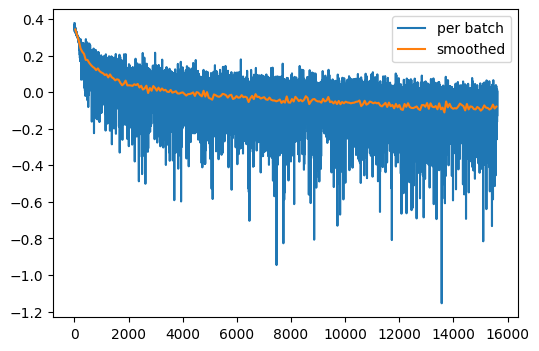

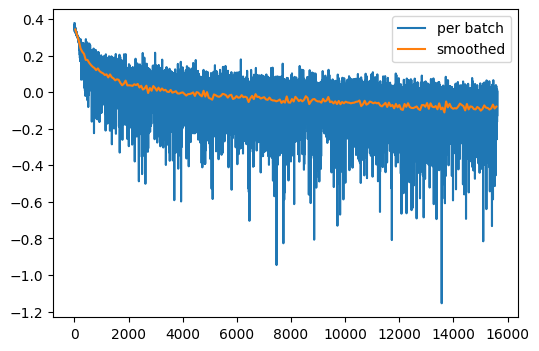

In [9]:
mb = master_bar(range(config.epochs))
mb.names = ['per batch','smoothed']
train_loss = []
valid_acc = []
test_acc = []
learning_rates = [optimizer.param_groups[0]['lr']]
i_step = 0
i_ckpt = 0
for i_epoch in mb:
    # training
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
        dataset['train'],
        batch_size=config.batch_size,
        sampler=sampler,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=train_collate_fn
    )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, (x,y) in enumerate(pb):
        y = y.to(torch.long).to(device)
        x = x.to(device).to(torch.float)/255
        for mix_transform in mix_transforms:
            x, y = mix_transform(x, y)

        logits = model(x-0.5)
        loss = torch.nn.CrossEntropyLoss()(input=logits, target=y)

        train_loss.append(loss.item())
        loss.backward()
        if (i_batch + 1) % config.grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # plotting and learning rate update
        if (i_step+1) % config.plot_update == 0:
            plot_n = len(train_loss) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(train_loss).reshape(plot_n, -1).mean(dim=1)
            train_x = range(len(train_loss))
            train_y = train_loss
            mb.update_graph([[train_x, np.log10(train_y)],[smoothed_x, np.log10(smoothed_y)]])

            # lr update
            schedule.step()
            learning_rates.append(optimizer.param_groups[0]['lr'])
    
        i_step+=1
        
    # validation
    model.eval()
    valid_acc.append(0)
    data_loader_valid = torch.utils.data.DataLoader(
        dataset['validation'],
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    pb_valid = progress_bar(data_loader_valid, parent=mb)
    for i_batch, (x, y) in enumerate(pb_valid):
        y = y.to(torch.long).to(device)
        x = x.to(device).to(torch.float)/255
        with torch.no_grad():
            logits = model(x-0.5)
        valid_acc[i_epoch] += torch.sum(logits.argmax(dim=1) == y).item()
    valid_acc[i_epoch] /= dataset['validation'].num_rows
    mb.main_bar.comment = f'validation accuracy {valid_acc[i_epoch]:.4g}'

    # test 
    test_acc.append(0)
    data_loader_test = torch.utils.data.DataLoader(
        dataset['test'],
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    pb_test = progress_bar(data_loader_test, parent=mb)
    for i_batch, (x, y) in enumerate(pb_test):
        y = y.to(torch.long).to(device)
        x = x.to(device).to(torch.float)/255
        with torch.no_grad():
            logits = model(x-0.5)
        test_acc[i_epoch] += torch.sum(logits.argmax(dim=1) == y).item()
    test_acc[i_epoch] /= dataset['test'].num_rows
    mb.main_bar.comment = f'test accuracy {test_acc[i_epoch]:.4g}'
    
    torch.save({
        'i_epoch': i_epoch,
        'learning_rates': learning_rates,
        'smoothed_y': smoothed_y,
        'valid_acc': valid_acc,
        'test_acc': test_acc,
        'config': config,
        'model_state_dict': model.state_dict(),
    }, f"log_{device}.pth")

    if valid_acc[-1]>config.target_acc:
        torch.save({
            'model_state_dict': model.state_dict(),
        }, f"w{i_epoch}_{device}.pth")
        i_ckpt += 1
        if i_ckpt>=config.N_median:
            break

In [10]:
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

(0.9, 1.0)

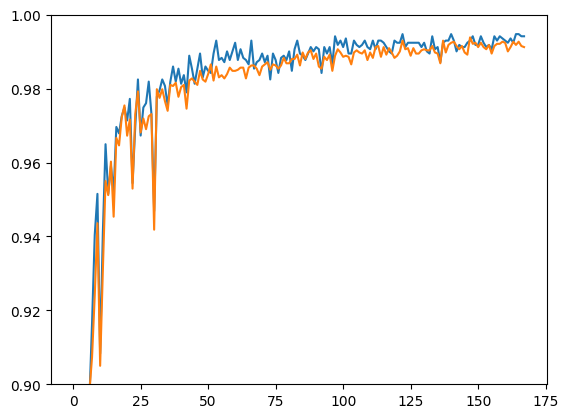

In [11]:
plt.plot(valid_acc)
plt.plot(test_acc)
plt.ylim([0.9,1.0])

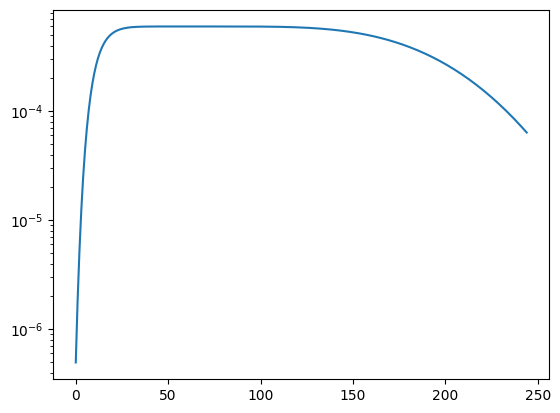

In [12]:
plt.semilogy(learning_rates)

/tmp/ipykernel_2006650/2013070528.py:2: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,2])


(0.7344660813644, 2)

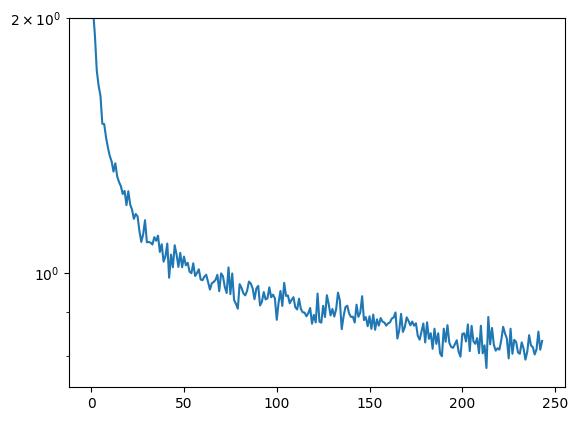

In [13]:
plt.semilogy(smoothed_y)
plt.ylim([0,2])

In [14]:
from glob import glob
file_list=sorted(glob('w*%s.pth'%device),key=lambda x:int(x.split('_')[0][1:]))[:15]

In [15]:
state_dicts = [torch.load(f, map_location='cpu', weights_only=True)['model_state_dict'] for f in file_list]
keys = state_dicts[0].keys()
median_state_dict = {}
for key in keys:
    param_values = torch.stack([state_dict[key] for state_dict in state_dicts])
    median_value = torch.median(param_values, dim=0).values
    median_state_dict[key] = median_value
model.load_state_dict(median_state_dict)

<All keys matched successfully>

In [16]:
model.eval()
test_acc.append(0)
data_loader_test = torch.utils.data.DataLoader(
    dataset['test'],
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    drop_last=False,
    pin_memory=True,
    collate_fn=valid_collate_fn
)
pb_test = progress_bar(data_loader_test)
for i_batch, (x, y) in enumerate(pb_test):
    y = y.to(torch.long).to(device)
    x = x.to(device).to(torch.float)/255
    with torch.no_grad():
        logits = model(x-0.5)
    test_acc[-1] += torch.sum(logits.argmax(dim=1) == y).item()
test_acc[-1] /= dataset['test'].num_rows

In [17]:
test_acc[-1]

0.9926921952645426

In [18]:
dataset['test'].num_rows/(pb_test.last_t/1e9)

1969.6372547768863